# Import Dependencies

In [311]:
import numpy as np  
import pandas as pd
import time

import tensorflow as tf
from tensorflow import keras
from keras.optimizers import Adam

from collections import deque

from typing import  Literal
import warnings
warnings.filterwarnings(action = 'ignore' , category = DeprecationWarning)

import matplotlib.pyplot as plt
import seaborn as sns


# Set Seaborn style
sns.set_style("darkgrid")

In [312]:
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.algorithms.moo.nsga2 import NSGA2

from pymoo.algorithms.soo.nonconvex.pso import PSO

from pymoo.optimize import minimize
from pymoo.problems import get_problem
from pymoo.util.ref_dirs import get_reference_directions


from pymoo.core.problem import Problem
from pymoo.operators.sampling.rnd import FloatRandomSampling

from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM

# initialize The First population Random Sampler

In [313]:
def initialize_population(population_size, num_variables, num_ojective):
    problem = Problem(n_var = num_variables, n_obj = num_ojective ,  xl=0, xu=1)
    sampling = FloatRandomSampling()
    X = sampling(problem, population_size).get("X")
    return X


# Function To use tradition EA Algorithm

In [314]:

def tradition_EA(name : str, 
                 population : np.ndarray,
                 cross_over_rate : float , 
                 mutation_over_rate : float ):
    ref_point = 1 if name == 'ackley' else 3
    # create the reference directions to be used for the optimization
    # ref_dirs = get_reference_directions("das-dennis", ref_point, n_partitions=population.shape[0])
    # create the algorithm object
    # replace with `NSGA3` if you want
    algorithm = NSGA2(pop_size=None,
                    # ref_dirs=ref_dirs,
                    sampling = population,
                     crossover=SBX( eta= 1 , prob= cross_over_rate ),
                     mutation=PM(eta=1, prob= mutation_over_rate ),)
    # execute the optimization
    problem = get_problem("ackley", n_var=population.shape[1], a=20, b=1/5, c=2 * np.pi)\
          if name == "ackley" else\
              get_problem(name, n_var = population.shape[1],
                                n_obj = 3
                                )

    res = minimize(problem,
                algorithm,
                seed=1,
                save_history = True,
                save_archive =True,
                termination= ( 'n_iter', 1))
    return res.X

# initialize First ANN weights in Random

In [315]:
# initialize_ANN
def initialize_ANN(n_var, lr = 0.1 , active_function = 'softmax'):
# Create the modelweights_randomly
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape = n_var,
                              name = "Input"),

        tf.keras.layers.Dense(n_var * 3,
                              activation = 'sigmoid',
                              name = "hidden"),
                              
        tf.keras.layers.Dense(n_var ,
                              activation = active_function,
                              name = "Output")
    ])

    model.compile(optimizer=Adam(lr), loss='mse',  metrics=['accuracy'])
    return model

# Function to Train the model

In [316]:
# train_ANN
def train_ANN(model,
               X_train : np.ndarray , 
               y_train : np.ndarray ) -> np.ndarray:
    
    hist = model.fit(X_train, y_train, epochs=1, verbose=False)
    
    return model, hist

# LEARNING-AIDED EVOLUTION Function

In [317]:
def leo(model 
        , X_train : np.ndarray) -> np.ndarray:
    ypred = model.predict(X_train, verbose=False)
    return  ypred

# Benckmark Functions

In [318]:
def fitness(name : str, 
            indivisual: np.ndarray , 
            n_variables: int,
            n_objective: int) -> float| np.ndarray:
    
    pf = get_problem(name, n_var = n_variables,
                                n_obj = n_objective
                                ).evaluate(indivisual)
    return pf
        

In [319]:
def selection(problem : str,
                individual_1 : np.ndarray,
                individual_2 : np.ndarray,
                n_variables : int ,
                n_objective : int) -> tuple[bool, np.ndarray]:
    
    fitness_individual_1 = fitness( problem, 
                                    individual_1,
                                    n_variables ,
                                    n_objective)
    
    fitness_individual_2 = fitness( problem, 
                                    individual_2,
                                    n_variables, 
                                    n_objective)

    if np.any( fitness_individual_1 <= fitness_individual_2):
        
        return  individual_1
    else:
        return  individual_2

In [367]:
def main(
    Problem : object,
    archive_size : int,
    lp : float,
    n_generations : int,
    first_gen_size : int,
    n_obj : int,
    n_var : int,
    cross_over_rate : float,
    mutation_rate : float,
    ANN_learning_rate : float,
    ANN_Activatvation_function : Literal['sigmoid' , 'softmax'],
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    
    time_to_run = list()

    global Xg
    Xg = initialize_population(first_gen_size, n_var, n_obj )  # Initialize population and evaluate fitness

    global ANN 
    ANN = initialize_ANN(1 if Problem == 'ackley' else n_var , 
                         ANN_learning_rate , ANN_Activatvation_function )  # Initialize ANN weights randomly
    

    archive = deque(maxlen = archive_size)

    all_losses  = list()
    all_accuracy = list()


    for gen in range(n_generations):
        print(f" gen: {gen+1}| ", end= "")

        start_time = time.time()


        r = np.random.uniform(0,1)
        if gen > 1 and r < lp:
            newX = leo(ANN, Xg)

        else :
            newX = tradition_EA(Problem, Xg, cross_over_rate, mutation_rate )

        newX_fitness = fitness(Problem, newX, n_var , n_obj)

        # SEP Collection
        for i in range(len(newX_fitness)):
            if np.any(fitness(Problem, Xg[i], n_var, n_obj) < fitness(Problem, newX[i], n_var, n_obj)):
                sep = (Xg[i] ,newX[i] )
                archive.append(sep)

        Xg = newX


        print(len(archive))

        for x1, x2 in archive:
            ANN,  history = train_ANN(ANN,  x1.reshape(1,-1),
                                                 x2.reshape(1,-1))

            all_losses.append( history.history['loss'][0] )
            all_accuracy.append( history.history['accuracy'][0] )

            

        end_time = time.time()
        time_delay = (end_time - start_time) * 1000 
        time_to_run.append(time_delay)
        
    loss = np.sum(all_losses) / len(archive)
    
    return archive, loss, all_accuracy , np.array(time_to_run)
     

In [368]:
PROBLEM =  'dtlz7'
ARCHIVE_SIZE = 100
LP = 0.5
N_GENERATORS = 5
FIRST_GEN_SIZE = 100
CROSS_OVER_RATE = .5
MUTATION_RATE = .9
N_OBJ = 10
N_VAR = 10
ANN_LR = .05
ANN_AC_FUNCTION = 'sigmoid'

Archive , loss ,  model_accuracy , timing = main(
    PROBLEM, # 
    archive_size = ARCHIVE_SIZE, # Archive size
    lp = LP,
    n_generations = N_GENERATORS, # number of generations
    first_gen_size = FIRST_GEN_SIZE, # number of generations 
    cross_over_rate = CROSS_OVER_RATE, # cross over rate
    mutation_rate = MUTATION_RATE, # mutation rate 
    n_obj= N_OBJ, # number of observations
    n_var= N_VAR, # number of variables
    ANN_learning_rate = ANN_LR, # learning rate
    ANN_Activatvation_function= ANN_AC_FUNCTION, # activation function for ANN

)

 gen: 1| 8
 gen: 2| 8
 gen: 3| 17
 gen: 4| 20
 gen: 5| 23


In [369]:
loss, model_accuracy

(0.16060956701909637,
 [0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  1.0,
  0.0,
  0.0,
  1.0,
  1.0,
  1.0,
  0.0,
  1.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0])

In [370]:
print(model_accuracy)

[0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [371]:
# only Traditional (NSGII)
print("NSGII")

Archive_NSG2  ,  loss_NSG2  , NSG2_accuracy,  timing_NSG2 = main(
                Problem = "dtlz3",
                archive_size = 100,
                lp = -1., # to make sure just PSO is running
                n_generations = 10 , # number of generations
                first_gen_size = 100, # number of generations 
                cross_over_rate = .5, # cross over rate
                mutation_rate = .9, # mutation rate 
                n_obj= 10, # number of observations
                n_var= 100, # number of variables
                ANN_learning_rate = .1, # learning rate
                ANN_Activatvation_function= "sigmoid", # activation function for ANN
)

print( "\nL-NSGII")
# both algorithm with posibilty of lp (L-PSO)

Archivee_L_NSG2 ,  loss_L_NSG2 , L_NSG2_accuracy , timing_L_NSG2 = main(
    Problem = "dtlz3",
    archive_size = 100,
    lp = .5,
    n_generations = 10, # number of generations
    first_gen_size = 100, # number of generations 
    cross_over_rate = .5, # cross over rate
    mutation_rate = .9, # mutation rate 
    n_obj= 10, # number of observations
    n_var= 100, # number of variables
    ANN_learning_rate = .1, # learning rate
    ANN_Activatvation_function= "sigmoid", # activation function for ANN
)

NSGII
 gen: 1| 49
 gen: 2| 49
 gen: 3| 49
 gen: 4| 49
 gen: 5| 49
 gen: 6| 49
 gen: 7| 49
 gen: 8| 49
 gen: 9| 49
 gen: 10| 49

L-NSGII
 gen: 1| 41
 gen: 2| 41
 gen: 3| 51
 gen: 4| 51
 gen: 5| 51
 gen: 6| 51
 gen: 7| 51
 gen: 8| 51
 gen: 9| 51
 gen: 10| 51


In [372]:
def ERR(EA, EB):
    """
    Calculate the Error Rate Ratio (ERR) between two values A and B.
    If B is greater than A, returns (B - A) / B * 100%.
    Otherwise, returns 0.
    """
    if EB > EA:
        return (EB - EA) / EB * 100
    else:
        return 0

def TIR(TA, TB):
    """
    Calculate the Time Interval Ratio (TIR) between two time values A and B.
    Returns (A - B) / B * 100%.
    """
    return (TA - TB) / TB * 100

def ETR(EA, EB, TA, TB):
    """
    Calculate the Error-to-Time Ratio (ETR) using ERR and TIR.
    Returns ERR(A, B) / TIR(A, B).
    """
    return ERR(EA, EB) / TIR(TA, TB)

# Example usage:
EA = loss_L_NSG2
EB = loss_NSG2
TA = timing_NSG2
TB = timing_L_NSG2

etr_result = ETR(EA, EB, TA , TB)
print(f"ETR: {etr_result}")


ETR: [ 0.9518344   1.43326485 -1.83262188  2.03494249 -8.66699916 -7.57875166
  6.77596146  1.47892335  1.68400331 -6.63009766]


In [373]:
print(f"error_L_NSG2 , {EA : .10f}")
print(f"error_NSG2 ,   {EB : .10f}")
print(f"Diffrence : {EA - EB}")
# print(f"time_NSG2 , {TA}")
# print(f"time_L_NSG2 , {TB}")


error_L_NSG2 ,  2.6632084921
error_NSG2 ,    3.2821577775
Diffrence : -0.6189492854232692


In [374]:
a = NSG2_accuracy
b = L_NSG2_accuracy


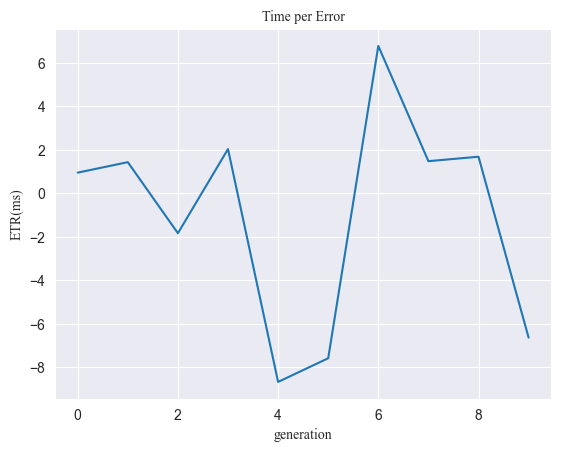

In [375]:
sns.lineplot(etr_result, markers = True)

plt.title(f"Time per Error"  , fontdict = {'font':  'Times new Roman'})
plt.xlabel(f"generation" , fontdict = {'font':  'Times new Roman'})
plt.ylabel(f"ETR(ms)" , fontdict = {'font' : 'Times new Roman'})
plt.savefig("ETR.png")
plt.show()

In [376]:
print(a)
print(b)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

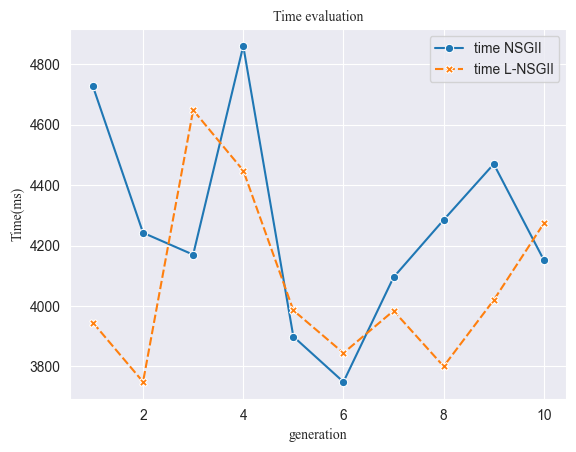

In [377]:
sns.lineplot(pd.DataFrame({
                            "time NSGII" : TA , 
                           "time L-NSGII" : TB
                           }, index = list(range(1, len(TA) +1))) , markers = True)

plt.title(f"Time evaluation"  , fontdict = {'font':  'Times new Roman'})
plt.xlabel(f"generation" , fontdict = {'font':  'Times new Roman'})
plt.ylabel(f"Time(ms)" , fontdict = {'font' : 'Times new Roman'})
plt.savefig("Time evaluation-NSGII.png")

plt.show()



In [378]:
import scipy.stats as stats

# One-sided test (alternative hypothesis: sample1 > sample2)
statistic, pvalue_greater = stats.wilcoxon(
                                        a,
                                        b,
                                    alternative='greater',
                                    zero_method = "zsplit")
print("One-sided p-value:", pvalue_greater)

# Two-sided test (alternative hypothesis: not equal medians)
statistic, pvalue_two_sided = stats.wilcoxon(a, b, zero_method = "zsplit" , 
                                   alternative='two-sided')
print("Two-sided p-value:", pvalue_two_sided)

One-sided p-value: 0.999999999754701
Two-sided p-value: 4.905980210396535e-10


In [379]:
# Perform Kruskal-Wallis test
import scipy.stats as stats

k_stat, p = stats.kruskal(a, b
                          )

print(f"""
kstat   => {k_stat} 
p value => {p }
""")


kstat   => 87.0222222222216 
p value => 1.0730865543951049e-20



In [381]:
# Only proceed to Cohon test if Kruskal-Wallis test is significant 
if p < 0.05:
    # Extract sum of ranks of each group
    n1 = len(a)
    sum_rank1 = stats.rankdata(a).sum()
    
    n2 = len(b)
    sum_rank2 = stats.rankdata(b).sum()

    # Compare sum of ranks between pairs using z statistic 
    z_12 = (sum_rank1 - sum_rank2)/np.sqrt(n1*n2*(n1+n2+1)/12)

    # Compare to critical value
    crit = 1.96
    p_12 = 2 * (1 - stats.norm.cdf(abs(z_12))) 

    # Print significant results
    print(p_12, 
        #   p_13, p_23
          )

1.0
